# Trains models with/without Dropout to examine how Dropout biases the reporting of uncertainty.
Dropout reduces the learning of higher-order interaction effects; there is higher uncertainty reported for predictions made based on higher-order interactions when reported by Dropout as opposed to Bootstrap resampling.

Reproduces Figure 9 in the paper.

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import Model, layers
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

from tensorflow import keras
tf.keras.backend.set_floatx('float64')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
def gen_data(n_samples, n_features, n_interactions):
    X = np.random.uniform(-1, 1, size=(n_samples, n_features))
    Y = np.zeros((n_samples, ))#np.random.normal(0, eps, size=(n_samples))
    for order, num in enumerate(n_interactions):
        order += 1
        for i in range(num):
            parts = np.random.choice(n_features, size=order, replace=False)
            thresh = np.percentile(X, 100 - (0.5**(1./order))*100)
            intx = X[:, parts[0]] > thresh
            for j in range(1, len(parts)):
                intx *= X[:, parts[j]] > thresh
            Y += intx
    return X, Y

In [3]:
# Measure NN confidence for effects of order k by Dropout and by ensembling

# Make NN
dropout_models = []
no_dropout_models = []
n_samples = 10000
n_features = 4
n_bootstraps = 10

from sklearn.metrics import mean_squared_error

# For order 1,...,k
max_order = 4
X_tests = {}
Y_tests = {}
for order in range(1, max_order+1):
    order_models_drop = []
    order_models_no_drop = []
    # Make data.
    n_interactions = [0] * max_order
    n_interactions[order-1] = 1
    X, Y = gen_data(n_samples*order, n_features, n_interactions=n_interactions)
    X = X.astype(np.float32)
    
    for iteration in range(n_bootstraps):
        print(order, iteration)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
        X_tests[(order, iteration)] = X_test
        Y_tests[(order, iteration)] = Y_test
        # Fit NN to data.
        width = 250
        depth = 5
        inputs = keras.Input(shape=(n_features,), dtype=tf.float32)
        x = keras.layers.Dense(width, dtype=tf.float32)(inputs)
        for _ in range(depth-1):
            outputs = keras.layers.Dropout(0.25, dtype=tf.float32)(x, training=True)
            outputs = keras.layers.Dense(width, activation='relu', dtype=tf.float32)(outputs)
        outputs = keras.layers.Dropout(0.25, dtype=tf.float32)(x, training=True)
        outputs = keras.layers.Dense(1, activation='sigmoid', dtype=tf.float32)(outputs)
        model = keras.Model(inputs, outputs)

        optimizer = tf.optimizers.Adam(1e-4)
        loss = tf.keras.losses.mean_squared_error
        model.compile(optimizer, loss)
        es = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=0,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )
        model.fit(X_train, Y_train, epochs=50, validation_split=0.25, callbacks=[es])
        # Measure MSE (should be comparable across orders)
        test_mse = mean_squared_error(Y_test, model(X_test).numpy())
        train_mse = mean_squared_error(Y_train, model(X_train).numpy())
        print(train_mse, test_mse)
        order_models_drop.append(model)
        
        inputs = keras.Input(shape=(n_features,), dtype=tf.float32)
        x = keras.layers.Dense(width, dtype=tf.float32)(inputs)
        outputs = x
        for _ in range(depth-1):
            outputs = keras.layers.Dense(width, activation='relu', dtype=tf.float32)(outputs)
        outputs = keras.layers.Dense(1, activation='sigmoid', dtype=tf.float32)(outputs)
        model = keras.Model(inputs, outputs)

        optimizer = tf.optimizers.Adam(1e-4)
        loss = tf.keras.losses.mean_squared_error
        model.compile(optimizer, loss)
        es = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=0,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )
        model.fit(X_train, Y_train, epochs=10, validation_split=0.25, callbacks=[es])
        test_mse = mean_squared_error(Y_test, model(X_test).numpy())
        train_mse = mean_squared_error(Y_train, model(X_train).numpy())
        print(train_mse, test_mse)
        order_models_no_drop.append(model)
        
    dropout_models.append(order_models_drop)
    no_dropout_models.append(order_models_no_drop)

0.494
1 0
Epoch 1/50
165/165 [==============================] - 1s 3ms/step - loss: 0.2067 - val_loss: 0.1774
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.1545 - val_loss: 0.1346
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.1205 - val_loss: 0.1063
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0874
Epoch 5/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0812 - val_loss: 0.0744
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0655
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0580
Epoch 8/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0520
Epoch 9/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0483
Epoch 10/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0462 - val_lo

165/165 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0125
Epoch 38/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 39/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 40/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 41/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 42/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0102
Epoch 43/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0104
0.011022637556047979 0.010300309389919927
Epoch 1/10
165/165 [==============================] - 1s 5ms/step - loss: 0.0779 - val_loss: 0.0104
Epoch 2/10
165/165 [==============================] - 1s 4ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 3/10
165/165 [==============================] - 1s 4ms/st

165/165 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0409
Epoch 12/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0379
Epoch 13/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0360
Epoch 14/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0336
Epoch 15/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0315
Epoch 16/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0295
Epoch 17/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0283
Epoch 18/50
165/165 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0268
Epoch 19/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0262 - val_loss: 0.0254
Epoch 20/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0245
Ep

329/329 [==============================] - 1s 3ms/step - loss: 0.0092 - val_loss: 0.0092
0.008000620988381531 0.009541218336541313
2 4
Epoch 1/50
329/329 [==============================] - 1s 2ms/step - loss: 0.1930 - val_loss: 0.1585
Epoch 2/50
329/329 [==============================] - 1s 2ms/step - loss: 0.1419 - val_loss: 0.1296
Epoch 3/50
329/329 [==============================] - 1s 2ms/step - loss: 0.1239 - val_loss: 0.1194
Epoch 4/50
329/329 [==============================] - 1s 2ms/step - loss: 0.1171 - val_loss: 0.1149
Epoch 5/50
329/329 [==============================] - 1s 2ms/step - loss: 0.1141 - val_loss: 0.1128
Epoch 6/50
329/329 [==============================] - 1s 2ms/step - loss: 0.1127 - val_loss: 0.1110
Epoch 7/50
329/329 [==============================] - 1s 2ms/step - loss: 0.1121 - val_loss: 0.1113
0.11221024237993403 0.1093089854636251
Epoch 1/10
329/329 [==============================] - 2s 8ms/step - loss: 0.0698 - val_loss: 0.0267
Epoch 2/10
329/329 [======

493/493 [==============================] - 3s 5ms/step - loss: 0.0122 - val_loss: 0.0136
0.012104413967051017 0.012746443394480864
3 7
Epoch 1/50
493/493 [==============================] - 1s 3ms/step - loss: 0.1978 - val_loss: 0.1675
Epoch 2/50
493/493 [==============================] - 1s 3ms/step - loss: 0.1594 - val_loss: 0.1562
Epoch 3/50
493/493 [==============================] - 1s 3ms/step - loss: 0.1547 - val_loss: 0.1546
Epoch 4/50
493/493 [==============================] - 1s 3ms/step - loss: 0.1537 - val_loss: 0.1543
Epoch 5/50
493/493 [==============================] - 1s 2ms/step - loss: 0.1537 - val_loss: 0.1540
Epoch 6/50
493/493 [==============================] - 1s 2ms/step - loss: 0.1535 - val_loss: 0.1540
0.153502361355375 0.1501937715492131
Epoch 1/10
493/493 [==============================] - 3s 5ms/step - loss: 0.0796 - val_loss: 0.0251
Epoch 2/10
493/493 [==============================] - 3s 5ms/step - loss: 0.0207 - val_loss: 0.0163
Epoch 3/10
493/493 [========

In [4]:
colors = ['blue', 'orange', 'green', 'red']

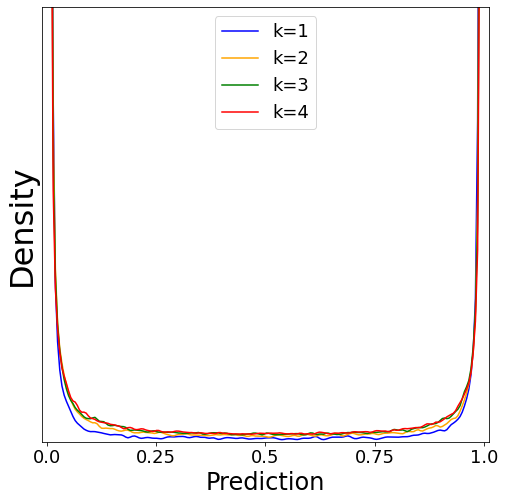

In [8]:
# No Dropout
fig = plt.figure(figsize=(8,8))

for order in range(1, max_order+1):
    variances = []
    for model_iter, model in enumerate(no_dropout_models[order-1]):
        n_dropouts = 10
        fixed_point = [X_tests[(order, model_iter)].copy() for _ in range(n_dropouts)] #np.zeros_like(X_train)
        outputs = [model(fixed_point[i]).numpy() for i in range(n_dropouts)]
        outputs  = np.mean(np.array(outputs), axis=0).squeeze()# / Y_tests[(order, model_iter)].squeeze()
        variances.extend(np.squeeze(outputs))
    sns.kdeplot(data=variances, label='k={}'.format(order),
                color=colors[order-1], clip=(0.0, 1.0),
                bw_adjust=0.1)
plt.legend(fontsize=18)
plt.xlabel("Prediction", fontsize=24)
plt.ylabel("Density", fontsize=32)
plt.yticks([])
plt.ylim([0.0, 5.0])
plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], ['0.0', '0.25', '0.5', '0.75', '1.0'], fontsize=18)
plt.xlim([-0.01, 1.01])
plt.savefig("results/predictions_no_dropout.pdf", bbox_inches='tight', dpi=300)
plt.show()

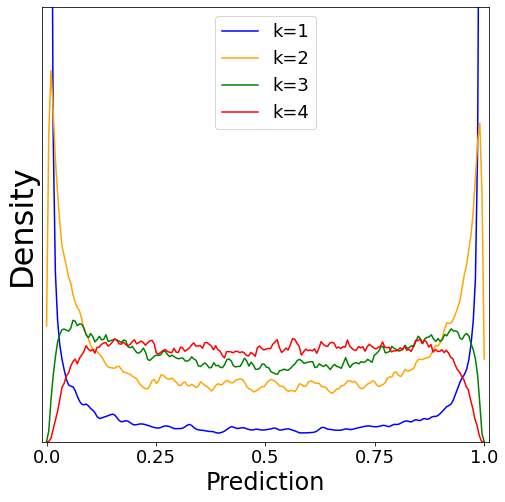

In [9]:
# Activation Dropout
fig = plt.figure(figsize=(8,8))

for order in range(1, max_order+1):
    variances = []
    for model_iter, model in enumerate(dropout_models[order-1]):
        n_dropouts = 1000
        fixed_point = [X_tests[(order, model_iter)].copy() for _ in range(n_dropouts)]
        outputs = [model(fixed_point[i]).numpy() for i in range(n_dropouts)]
        outputs  = np.mean(np.array(outputs), axis=0).squeeze()
        variances.extend(np.squeeze(outputs))
    sns.kdeplot(data=variances, label='k={}'.format(order),
                color=colors[order-1], clip=(0.0, 1.0),
                bw_adjust=0.1)
plt.legend(fontsize=18)
plt.xlabel("Prediction", fontsize=24)
plt.ylabel("Density", fontsize=32)

plt.ylim([0, 5])
plt.yticks([])
plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], ['0.0', '0.25', '0.5', '0.75', '1.0'], fontsize=18)
plt.xlim([-0.01, 1.01])#0.2])
plt.savefig("results/predictions_dropout.pdf", bbox_inches='tight', dpi=300)
plt.show()

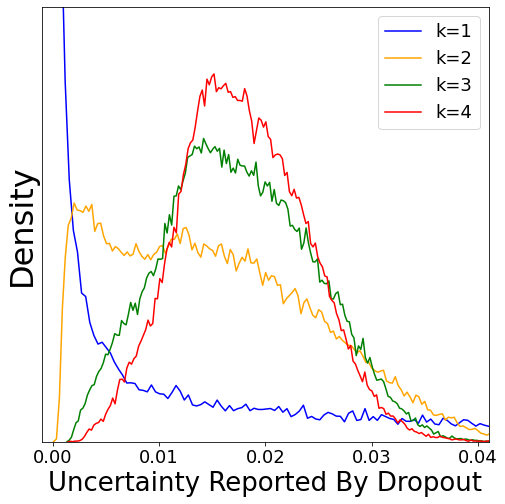

In [15]:
# Activation Dropout Uncertainty
fig = plt.figure(figsize=(8,8))

for order in range(1, max_order+1):
    variances = []
    for model_iter, model in enumerate(dropout_models[order-1]):
        n_dropouts = 100
        fixed_point = [X_tests[(order, model_iter)].copy() for _ in range(n_dropouts)]
        outputs = [model(fixed_point[i]).numpy() for i in range(n_dropouts)]
        outputs  = np.std(np.array(outputs), axis=0)
        variances.extend(np.squeeze(outputs))
    sns.kdeplot(data=np.array(variances), label='k={}'.format(order),
                color=colors[order-1], clip=(0.0, 1.0),
                bw_adjust=0.1)
plt.legend(fontsize=18)
plt.xlabel("Uncertainty Reported By Dropout", fontsize=26)
plt.ylabel("Density", fontsize=32)
plt.xlim([-0.001, 0.041])
plt.ylim([0, 80])
plt.yticks([])
plt.xticks([0.0, 0.01, 0.02, 0.03, 0.04], ['0.00', '0.01', '0.02', '0.03', '0.04'], fontsize=18)
plt.savefig("results/uncertainty_dropout.pdf", bbox_inches='tight', dpi=300)
plt.show()

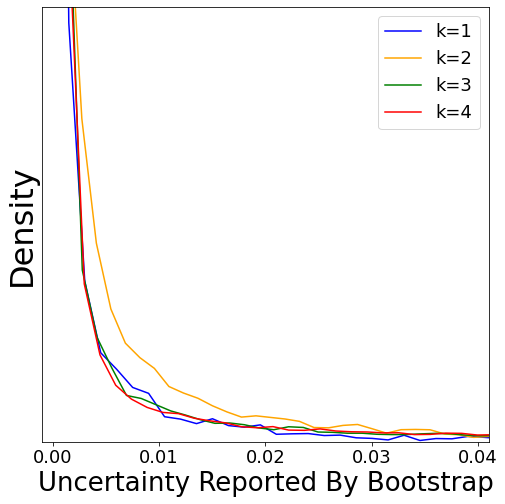

In [18]:
# Bagging Uncertainty
fig = plt.figure(figsize=(8,8))
bagging_uncertainty = []
for order in range(1, max_order+1):
    order_models = no_dropout_models[order-1]
    fixed_point = X_tests[(order, 0)].copy()
    outputs = np.array([model(fixed_point).numpy() for model in order_models])
    uncertainties = np.std(outputs, axis=0)
    bagging_uncertainty.append(uncertainties)
    sns.kdeplot(data=uncertainties.squeeze(), label='k={}'.format(order),
                color=colors[order-1], clip=(0.0, 1.0),
                bw_adjust=0.1)
plt.legend(fontsize=18)
plt.xlabel("Uncertainty Reported By Bootstrap", fontsize=26)
plt.ylabel("Density", fontsize=32)
plt.ylim([0, 100])
plt.yticks([])
plt.xlim([-0.001, 0.041])
plt.xticks([0.0, 0.01, 0.02, 0.03, 0.04], ['0.00', '0.01', '0.02', '0.03', '0.04'], fontsize=18)
plt.savefig("results/uncertainty_bootstrap.pdf", bbox_inches='tight', dpi=300)
plt.show()